<a href="https://colab.research.google.com/github/chungntu/1DCNN-LSTM-ResNet/blob/main/Problem_13_3D_frame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== DISPLACEMENTS ===
DOF  1:  0.00000000e+00
DOF  2:  0.00000000e+00
DOF  3:  0.00000000e+00
DOF  4:  0.00000000e+00
DOF  5:  0.00000000e+00
DOF  6:  0.00000000e+00
DOF  7:  0.00000000e+00
DOF  8:  0.00000000e+00
DOF  9:  0.00000000e+00
DOF 10:  0.00000000e+00
DOF 11:  0.00000000e+00
DOF 12:  0.00000000e+00
DOF 13:  0.00000000e+00
DOF 14:  0.00000000e+00
DOF 15:  0.00000000e+00
DOF 16:  0.00000000e+00
DOF 17:  0.00000000e+00
DOF 18:  0.00000000e+00
DOF 19:  0.00000000e+00
DOF 20:  0.00000000e+00
DOF 21:  0.00000000e+00
DOF 22:  0.00000000e+00
DOF 23:  0.00000000e+00
DOF 24:  0.00000000e+00
DOF 25: -2.27292586e-03
DOF 26: -3.92541936e-06
DOF 27:  1.15845158e-03
DOF 28:  7.08243376e-05
DOF 29:  1.37718726e-04
DOF 30:  2.37484340e-04
DOF 31: -1.06187895e-03
DOF 32: -6.16126313e-06
DOF 33:  1.15834567e-03
DOF 34:  7.20065641e-05
DOF 35:  6.46084125e-04
DOF 36:  1.13241778e-04
DOF 37: -1.06723943e-03
DOF 38:  5.80661535e-06
DOF 39: -1.16611682e-03
DOF 40: -7.27359595e-05
DOF 41:  7.5247771

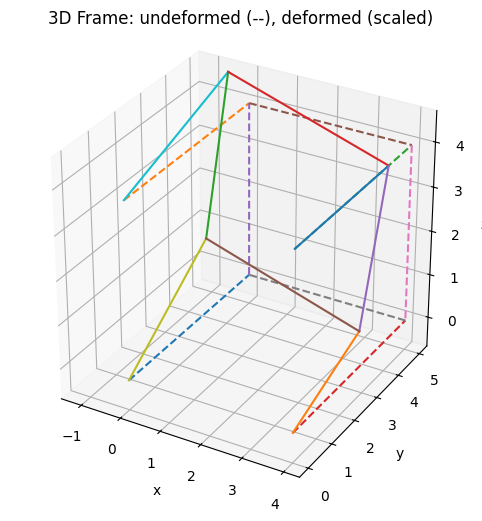

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# formStiffness3Dframe (MATCH MATLAB EXACTLY)
# ============================================================
def formStiffness3Dframe(GDoF, numberElements, elementNodes, numberNodes, nodeCoordinates,
                         E, A, Iz, Iy, G, J):

    stiffness = np.zeros((GDoF, GDoF), dtype=float)

    for e in range(numberElements):
        n1 = int(elementNodes[e, 0])  # 1-based
        n2 = int(elementNodes[e, 1])  # 1-based

        # element DOF mapping (MATLAB): [6*n1-5 ... 6*n1, 6*n2-5 ... 6*n2]
        dof1 = np.arange(6*(n1-1), 6*(n1-1) + 6)  # 0-based
        dof2 = np.arange(6*(n2-1), 6*(n2-1) + 6)
        elementDof = np.hstack([dof1, dof2])

        x1, y1, z1 = nodeCoordinates[n1-1, :]
        x2, y2, z2 = nodeCoordinates[n2-1, :]

        L = np.sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)

        k1  = E*A/L
        k2  = 12*E*Iz/(L**3)
        k3  =  6*E*Iz/(L**2)
        k4  =  4*E*Iz/L
        k5  =  2*E*Iz/L
        k6  = 12*E*Iy/(L**3)
        k7  =  6*E*Iy/(L**2)
        k8  =  4*E*Iy/L
        k9  =  2*E*Iy/L
        k10 = G*J/L

        a = np.array([[k1, 0, 0],
                      [0,  k2, 0],
                      [0,  0,  k6]], dtype=float)

        b = np.array([[0,  0,   0],
                      [0,  0,  k3],
                      [0, -k7,  0]], dtype=float)

        c = np.array([[k10, 0,  0],
                      [0,   k8, 0],
                      [0,   0,  k4]], dtype=float)

        d = np.array([[-k10, 0,  0],
                      [0,    k9, 0],
                      [0,    0,  k5]], dtype=float)

        # MATLAB EXACT:
        # k = [ a  b  -a  b ;
        #       b' c   b  d ;
        #      (-a)' b'  a -b ;
        #       b' d' (-b)' c ];
        k = np.block([
            [ a,     b,    -a,     b   ],
            [ b.T,   c,     b,     d   ],
            [ (-a).T, b.T,  a,    -b   ],
            [ b.T,   d.T, (-b).T,  c   ],
        ])

        # Lambda (direction cosines) exactly like MATLAB
        if (x1 == x2) and (y1 == y2):
            if z2 > z1:
                Lambda = np.array([[0, 0,  1],
                                   [0, 1,  0],
                                   [-1,0,  0]], dtype=float)
            else:
                Lambda = np.array([[0, 0, -1],
                                   [0, 1,  0],
                                   [1, 0,  0]], dtype=float)
        else:
            CXx = (x2-x1)/L
            CYx = (y2-y1)/L
            CZx = (z2-z1)/L

            D = np.sqrt(CXx*CXx + CYx*CYx)

            CXy = -CYx/D
            CYy =  CXx/D
            CZy = 0.0

            CXz = -CXx*CZx/D
            CYz = -CYx*CZx/D
            CZz = D

            Lambda = np.array([[CXx, CYx, CZx],
                               [CXy, CYy, CZy],
                               [CXz, CYz, CZz]], dtype=float)

        # R blockdiag(Lambda, Lambda, Lambda, Lambda)
        R = np.zeros((12, 12), dtype=float)
        R[0:3,   0:3]   = Lambda
        R[3:6,   3:6]   = Lambda
        R[6:9,   6:9]   = Lambda
        R[9:12,  9:12]  = Lambda

        ke = R.T @ k @ R
        stiffness[np.ix_(elementDof, elementDof)] += ke

    return stiffness


def solution(GDoF, prescribedDof_1based, stiffness, force):
    prescribed = np.array(prescribedDof_1based, dtype=int) - 1
    all_dofs = np.arange(GDoF)
    free = np.setdiff1d(all_dofs, prescribed)

    U = np.zeros((GDoF,), dtype=float)
    Kff = stiffness[np.ix_(free, free)]
    Ff = force[free]
    U[free] = np.linalg.solve(Kff, Ff)
    U[prescribed] = 0.0
    return U


def drawingMesh(nodeCoordinates, elementNodes, ax=None, linestyle='-'):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    for (n1, n2) in elementNodes:
        p1 = nodeCoordinates[n1-1]
        p2 = nodeCoordinates[n2-1]
        ax.plot([p1[0], p2[0]],
                [p1[1], p2[1]],
                [p1[2], p2[2]], linestyle)

    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
    ax.set_box_aspect([1, 1, 1])
    return ax


# ============================================================
# MAIN (problem13.m)
# ============================================================
E  = 210e6
A  = 0.02
Iy = 10e-5
Iz = 20e-5
J  = 5e-5
G  = 84e6

nodeCoordinates = np.array([
    [0, 0, 0],
    [0, 0, 4],
    [4, 0, 4],
    [4, 0, 0],
    [0, 5, 0],
    [0, 5, 4],
    [4, 5, 4],
    [4, 5, 0],
], dtype=float)

elementNodes = np.array([
    [1, 5],
    [2, 6],
    [3, 7],
    [4, 8],
    [5, 6],
    [6, 7],
    [7, 8],
    [8, 5],
], dtype=int)

numberNodes = nodeCoordinates.shape[0]
numberElements = elementNodes.shape[0]
GDoF = 6 * numberNodes

force = np.zeros((GDoF,), dtype=float)
force[36] = -15.0  # MATLAB force(37)=-15

stiffness = formStiffness3Dframe(GDoF, numberElements, elementNodes, numberNodes,
                                 nodeCoordinates, E, A, Iz, Iy, G, J)

prescribedDof = list(range(1, 24+1))
U = solution(GDoF, prescribedDof, stiffness, force)

print("=== DISPLACEMENTS ===")
for i, val in enumerate(U, start=1):
    print(f"DOF {i:2d}: {val: .8e}")

# plot
scale = 500.0
Ux = U[0::6]; Uy = U[1::6]; Uz = U[2::6]
nodeDef = nodeCoordinates + scale * np.column_stack([Ux, Uy, Uz])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
drawingMesh(nodeCoordinates, elementNodes, ax=ax, linestyle='--')
drawingMesh(nodeDef, elementNodes, ax=ax, linestyle='-')
ax.set_title('3D Frame: undeformed (--), deformed (scaled)')
plt.show()
